In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

with zipfile.ZipFile('/content/drive/MyDrive/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
!pip install pyswarm


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=8b413b8f80437fb87c3b91afc084e79bb3a5212382c8b3c476194bcf9845ffc6
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import warnings
from pyswarm import pso

# Suppress warnings
warnings.filterwarnings("ignore")


Total Number of Classes: 5 
Class Names: ['lung_n' 'lung_scc' 'lung_aca' 'colon_aca' 'colon_n']


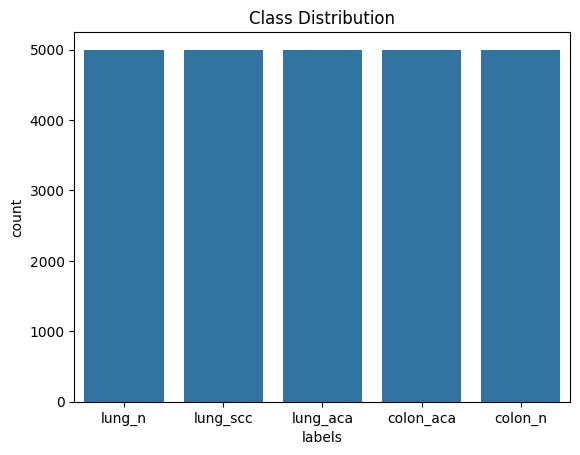

In [ ]:
# Define dataset directories for both lung and colon image sets
data_dir = '/content/lung_colon_image_set'
categories = ['lung_image_sets', 'colon_image_sets']
filepaths = []
labels = []

# Loop through both lung and colon datasets and gather file paths and labels
for category in categories:
    category_dir = os.path.join(data_dir, category)
    classes = os.listdir(category_dir)
    for class_name in classes:
        class_dir = os.path.join(category_dir, class_name)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(class_name)

# Create a DataFrame from file paths and labels
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Print number of classes and class names
class_names = df['labels'].unique()
n_classes = len(class_names)
print(f"Total Number of Classes: {n_classes} \nClass Names: {class_names}")

# Check class balance
sns.countplot(x=df['labels'])
plt.title('Class Distribution')
plt.show()



In [ ]:
# Split the data into training, validation, and test sets
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123)

print(f"Train length: {len(train_df)}, Test length: {len(test_df)}, Validation length: {len(valid_df)}")

# Data preprocessing using ImageDataGenerator
image_size = (224, 224)
batch_size = 16

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=image_size, class_mode='categorical',
                                       shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=image_size, class_mode='categorical',
                                       shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=image_size, class_mode='categorical',
                                      shuffle=False, batch_size=batch_size)




Train length: 20000, Test length: 2500, Validation length: 2500
Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [ ]:
# Define CNN model dynamically based on PSO-suggested architecture and hyperparameters
def create_cnn_model(learning_rate, dropout_rate, filters_per_layer, num_layers):
    model = Sequential()
    input_shape = (224, 224, 3)

    # Dynamically add convolutional layers
    for i in range(num_layers):
        if i == 0:
            model.add(Conv2D(filters_per_layer[i], (3, 3), padding="same", activation="relu", input_shape=input_shape))
        else:
            model.add(Conv2D(filters_per_layer[i], (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation="softmax"))

    # Compile the model
    model.compile(Adamax(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Fitness function for PSO
def fitness_function(hyperparams):
    from tensorflow.keras import backend as K

    learning_rate, dropout_rate, num_layers, num_filters = hyperparams
    num_layers = int(num_layers)
    filters_per_layer = [int(num_filters)] * num_layers

    model = create_cnn_model(learning_rate, dropout_rate, filters_per_layer, num_layers)
    history = model.fit(train_gen, epochs=3, validation_data=valid_gen, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    K.clear_session()

    return -val_accuracy

# PSO bounds
lower_bounds = [1e-5, 0.1, 2, 32]
upper_bounds = [1e-3, 0.4, 4, 128]

# Run PSO optimization
best_hyperparams, _ = pso(fitness_function, lower_bounds, upper_bounds, swarmsize=5, maxiter=5)

# Extract the best hyperparameters
optimal_learning_rate, optimal_dropout_rate, optimal_layers, optimal_filters = best_hyperparams
print(f"Optimal hyperparameters: Learning Rate={optimal_learning_rate}, Dropout Rate={optimal_dropout_rate}, "
      f"Number of Layers={int(optimal_layers)}, Filters per Layer={int(optimal_filters)}")



Stopping search: maximum iterations reached --> 5
Optimal hyperparameters: Learning Rate=0.0008148845509675401, Dropout Rate=0.10780127317943096, Number of Layers=3, Filters per Layer=87


In [ ]:
# Train the final model with optimal hyperparameters
final_model = create_cnn_model(optimal_learning_rate, optimal_dropout_rate,
                               [int(optimal_filters)] * int(optimal_layers), int(optimal_layers))

history = final_model.fit(train_gen, epochs=10, validation_data=valid_gen)



Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 98ms/step - accuracy: 0.6845 - loss: 0.7514 - val_accuracy: 0.8556 - val_loss: 0.3481
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.8991 - loss: 0.2600 - val_accuracy: 0.9264 - val_loss: 0.2094
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - accuracy: 0.9428 - loss: 0.1558 - val_accuracy: 0.9232 - val_loss: 0.1931
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 91ms/step - accuracy: 0.9618 - loss: 0.1009 - val_accuracy: 0.9612 - val_loss: 0.1076
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 88ms/step - accuracy: 0.9763 - loss: 0.0646 - val_accuracy: 0.9516 - val_loss: 0.1370
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 90ms/step - accuracy: 0.9897 - loss: 0.0317 - val_accuracy: 0.9620 - val_loss: 0.1138
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.9925 - loss: 0.0240 - val_accuracy: 0.9648 - val_loss: 0.1050
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 90ms/step - accuracy: 

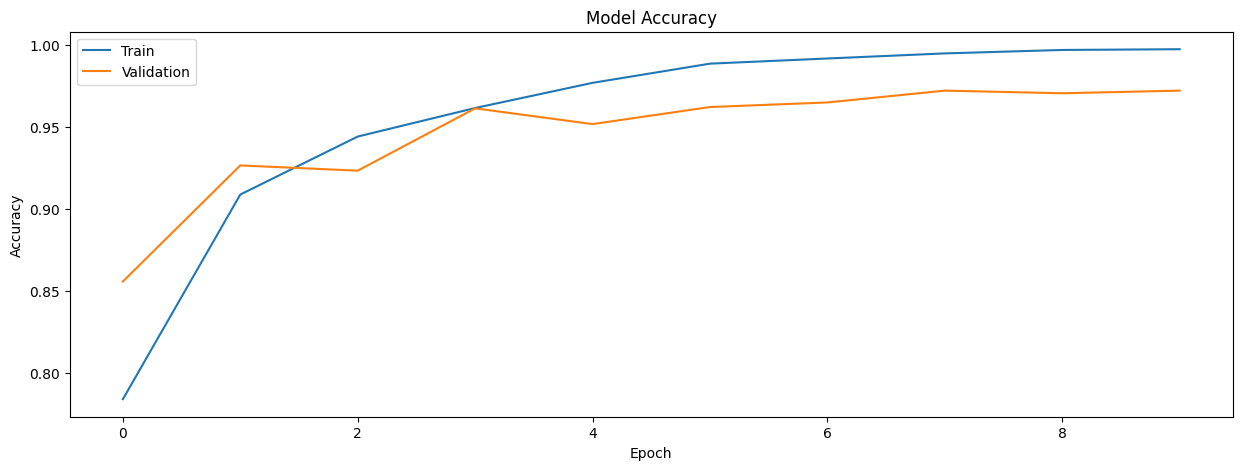

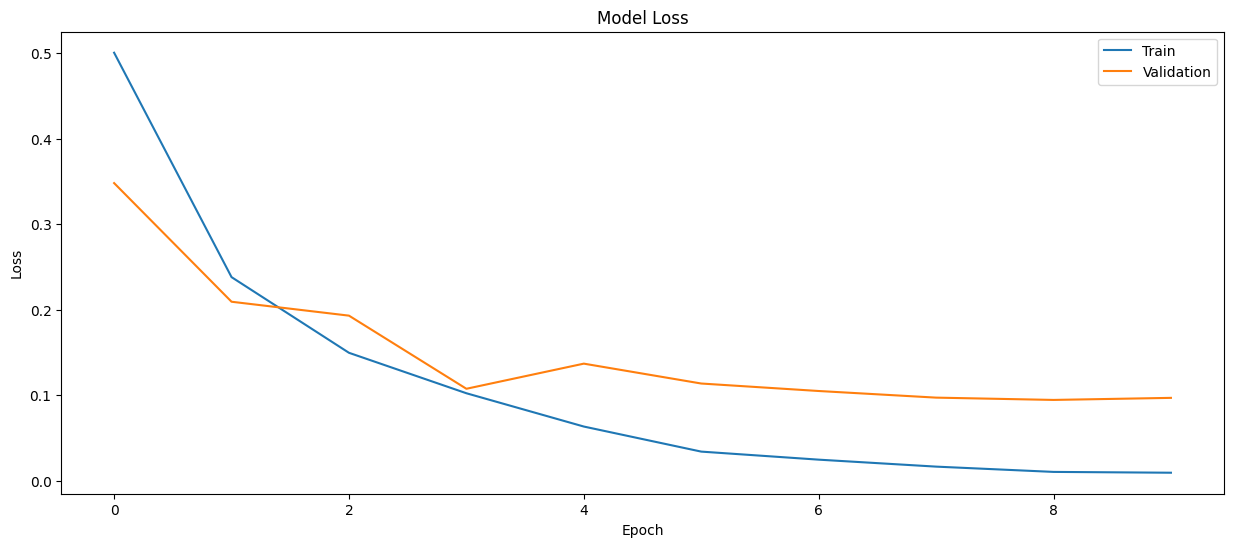

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [ ]:
# Evaluate the model
train_score = final_model.evaluate(train_gen, verbose=1)
valid_score = final_model.evaluate(valid_gen, verbose=1)
test_score = final_model.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]}, Train Accuracy: {train_score[1]}")
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.9999 - loss: 0.0012
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9728 - loss: 0.0835
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9650 - loss: 0.1189
Train Loss: 0.0011810449650511146, Train Accuracy: 0.9999499917030334
Validation Loss: 0.09701059758663177, Validation Accuracy: 0.972000002861023
Test Loss: 0.10103803128004074, Test Accuracy: 0.9700000286102295


In [ ]:
# Save the final model
final_model.save('Lung_Colon_Cancer_Model_PSO.h5')

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step


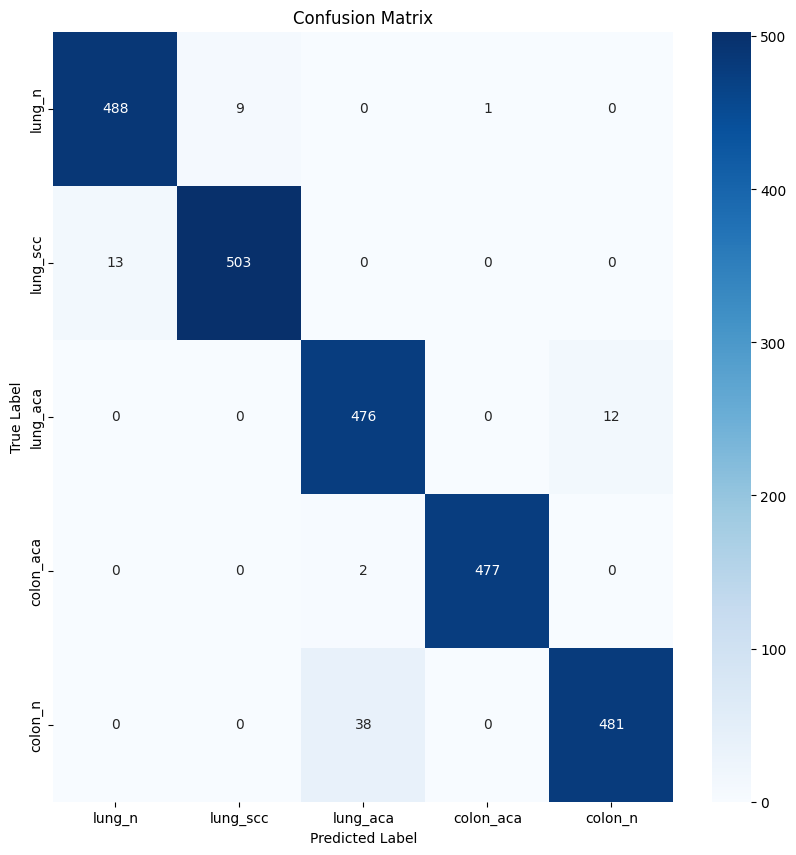

In [ ]:
# Confusion matrix
preds = final_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      lung_n       0.97      0.98      0.98       498
    lung_scc       0.98      0.97      0.98       516
    lung_aca       0.92      0.98      0.95       488
   colon_aca       1.00      1.00      1.00       479
     colon_n       0.98      0.93      0.95       519

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500

